# GeophPy Tutorial: Magnetic Data Processing

This notebook demonstrates the magnetic geophysical filtering and processing steps available in `geophpy`. We will take a raw, interpolated dataset and apply a sequence of filters to clean it and enhance archaeological features.

**By the end of this tutorial, you will know how to:**
* Apply a thre xxxxxshold filter to remove extreme values.
* xxxxx


In [1]:
# --- Imports ---
from geophpy import Survey
import geophpy
import matplotlib.pyplot as plt
import os
import numpy as np
# Displays the version to check the environment
print(f"Using GeophPy version: {geophpy.__version__}")

Using GeophPy version: 0.35.1


In [2]:
# --- Load the Data ---
data_dir = os.path.join('..', 'data')
data_file = 'Mag_ex1.dat'
filepath = os.path.join(data_dir, data_file)
print(filepath)

mag_survey = Survey.from_file(
    filepath,
    #delimiter=',',
    skiprows=1,
    x_colnum=0,
    y_colnum=1,
    z_colnum=4
)

if mag_survey:
    print(f"Successfully created Survey object: '{mag_survey.name}'")
    mag_survey.interpolate(x_step=0.15, y_step=0.15)
    print(f"Successfully created and interpolated Survey object: '{mag_survey.name}'")

# if 'mag_survey' in locals() and mag_survey.grid:
#     #valmin, valmax = -20, 20
    
#     mag_survey.plot_summary()
#     plt.show()

..\data\Mag_ex1.dat
Successfully created Survey object: 'Mag_ex1'
Successfully created and interpolated Survey object: 'Mag_ex1'


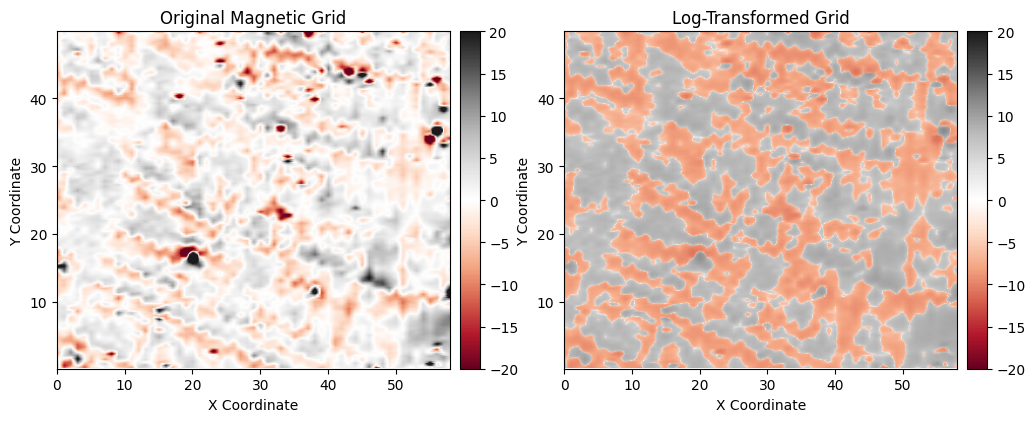

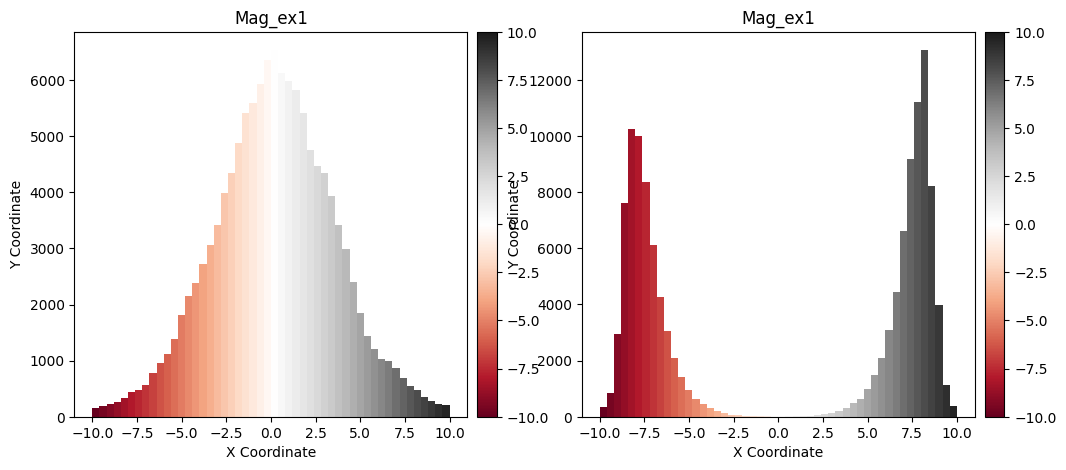

In [3]:
# 3. Now you can directly call the magnetic-specific method!
if mag_survey.grid:
    mag_survey.info.cmapname = 'RdGy'
    valmin, valmax = -20, 20
    # This method comes from the MagneticGridMixin we just added
    log_transformed_survey = mag_survey.log_transform_grid(mult_factor=1e3)

    # Visualize the result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    mag_survey.plot('2D-SURFACE', ax=ax1, title='Original Magnetic Grid', vmin=valmin, vmax=valmax)
    log_transformed_survey.plot('2D-SURFACE', ax=ax2, title='Log-Transformed Grid',
                                 vmin=valmin, vmax=valmax
                                 )

    # Visualize the histograms
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    mag_survey.plot_grid_histogram(ax=ax3, colored=True,
                                   cmap=mag_survey.info.cmapname, 
                                   range=(-10, 10)
                                   )
      
    log_transformed_survey.plot_grid_histogram(ax=ax4, colored=True,
                                               cmap=mag_survey.info.cmapname, 
                                               range=(-10, 10)
                                               )  
   
    plt.show()

### 3. Analytic Signal Filter

The analytic signal is a powerful tool for locating the edges of magnetic sources, as it is less sensitive to the direction of the remnant magnetization. The `analytic_signal_grid` method calculates this in the frequency domain.

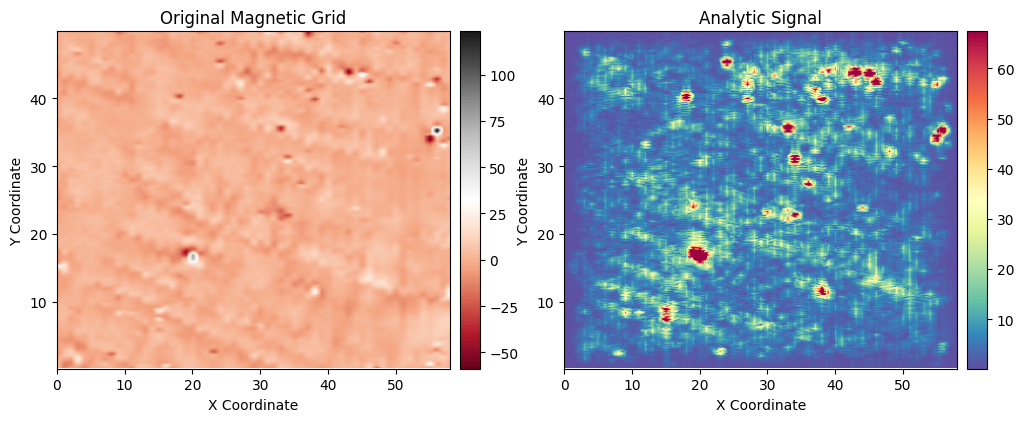

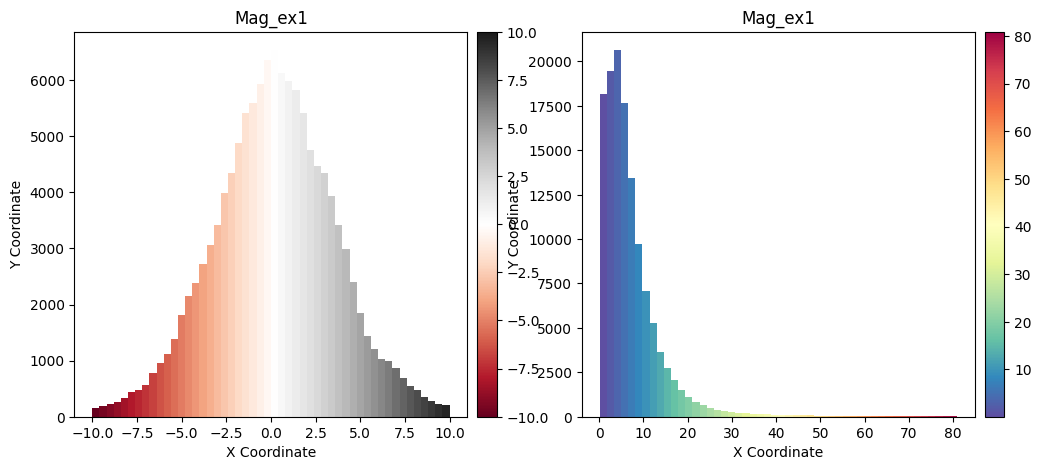

In [15]:
if 'mag_survey' in locals() and mag_survey.grid:
    # Apply the analytic signal filter
    nan_mask = np.isnan(mag_survey.grid.z_image)
#    valmin, valmax = np.percentile(as_grid_values[~nan_mask], (2, 98))

    #valmin, valmax = -10, 10
    

    analytic_signal_survey = mag_survey.analytic_signal_grid()
    analytic_signal_survey.info.cmapname = mag_survey.info.cmapname + '_r'

    # Visualize the before and after
    # We use a different colormap which is often better for analytic signal plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    mag_survey.plot('2D-SURFACE', ax=ax1, title='Original Magnetic Grid',
                                #vmin=valmin, vmax=valmax
                                )
    
    as_grid_values = analytic_signal_survey.grid.z_image
    #nan_mask = np.isnan(as_grid_values)
    valmin, valmax = np.percentile(as_grid_values[~nan_mask], (.5, 99.5))
    analytic_signal_survey.plot('2D-SURFACE', ax=ax2, title='Analytic Signal',
                                vmin=valmin, vmax=valmax,
                                cmap='Spectral_r'
                                 )

    # Visualize the histograms
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    mag_survey.plot_grid_histogram(ax=ax3, colored=True,
                                   cmap=mag_survey.info.cmapname, 
                                   range=(-10, 10)
                                   )
      
    analytic_signal_survey.plot_grid_histogram(ax=ax4, colored=True,
                                               cmap='Spectral_r', 
                                               range=(valmin*0.8, valmax*1.2)
                                               )  
    #plt.tight_layout()
    plt.show()

### 4. Field Continuation Filter

Field continuation is a powerful frequency-domain filter that recalculates the magnetic field as if it were measured at a different altitude. We can use the `continue_field_grid()` method for this.
* **Upward Continuation (`height` > 0):** Simulates measuring the data from higher up. This has a smoothing effect and emphasizes broader, deeper sources.
* **Downward Continuation (`height` < 0):** Simulates measuring the data closer to the sources. This has a sharpening effect and can enhance the resolution of shallow anomalies, but it can also amplify noise.

#### 4a. Upward Continuation

Let's continue the field upward by 5 meters. We expect to see a smoother map where the shorter wavelength (shallower) anomalies are attenuated.

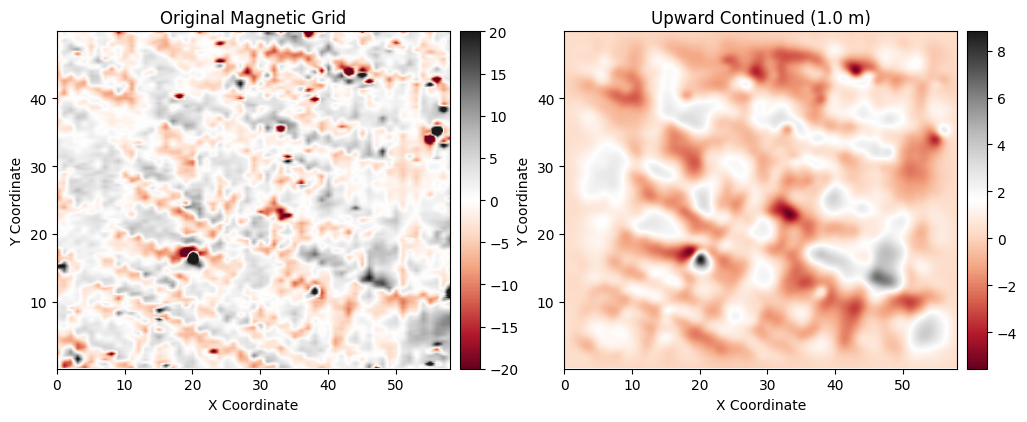

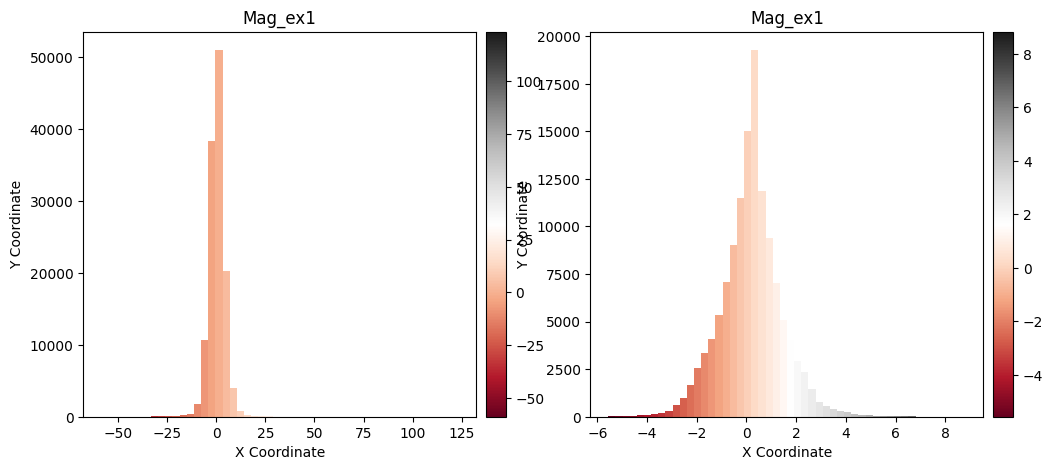

In [16]:
if 'mag_survey' in locals() and mag_survey.grid:
    valmin, valmax = -20, 20
    # Apply the upward continuation filter
    upward_height = 1.0
    upward_survey = mag_survey.continue_field_grid(height=upward_height)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    mag_survey.plot('2D-SURFACE', ax=ax1, title='Original Magnetic Grid',
                    vmin=valmin, vmax=valmax
                    )
    upward_survey.plot('2D-SURFACE', ax=ax2, title=f'Upward Continued ({upward_height} m)',
                    #vmin=valmin, vmax=valmax
                    )
    
    # Visualize the histograms
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    mag_survey.plot_grid_histogram(ax=ax3, colored=True,
                                   cmap=mag_survey.info.cmapname, 
                                   #range=(-10, 10)
                                   )
      
    upward_survey.plot_grid_histogram(ax=ax4, colored=True,
                                               cmap=upward_survey.info.cmapname, 
                                               #range=(valmin*0.8, valmax*1.2)
                                               )  
    plt.show()

#### 4b. Downward Continuation

Now, let's continue the field downward by 2 meters. This is a more sensitive operation. We expect to see the anomalies become sharper and more defined, but be aware that it can also increase noise in the data.

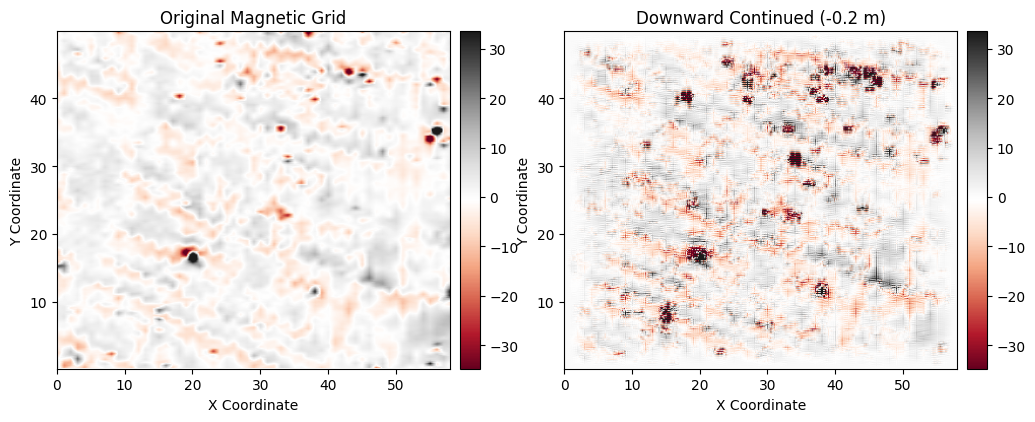

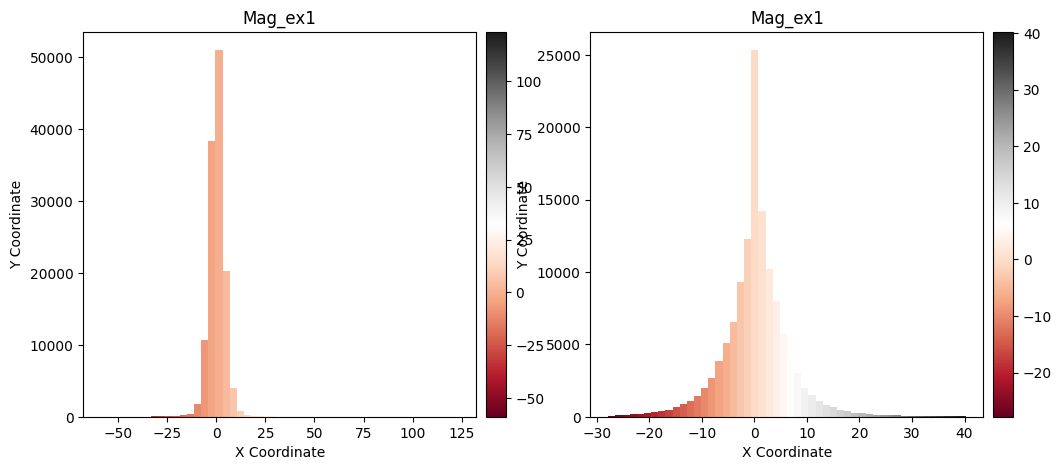

In [17]:
if 'mag_survey' in locals() and mag_survey.grid:
    valmin, valmax = -20, 20
    # Apply the downward continuation filter
    downward_height = -.2
    downward_survey = mag_survey.continue_field_grid(height=downward_height)
    
    nan_mask = np.isnan(downward_survey.grid.z_image)
    downward_values = downward_survey.grid.z_image
    valmin, valmax = np.percentile(downward_values[~nan_mask], (.5, 99.5))

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    mag_survey.plot('2D-SURFACE', ax=ax1, title='Original Magnetic Grid',
                    vmin=valmin, vmax=valmax
                    )
    downward_survey.plot('2D-SURFACE', ax=ax2, title=f'Downward Continued ({downward_height} m)',
                    vmin=valmin, vmax=valmax
                    )
    
    # Visualize the histograms
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    mag_survey.plot_grid_histogram(ax=ax3, colored=True,
                                   cmap=mag_survey.info.cmapname, 
                                   #range=(-10, 10)
                                   )
      
    downward_survey.plot_grid_histogram(ax=ax4, colored=True,
                                               cmap=downward_survey.info.cmapname, 
                                               range=(valmin*0.8, valmax*1.2)
                                               )  
    plt.show()

### 5. Reduction to the Pole (RTP)

Magnetic anomalies are naturally dipolar (having a positive and a negative part) and are skewed depending on the magnetic latitude of the survey. The **Reduction to the Pole** filter is a powerful technique that recalculates the data as if it were measured at the magnetic north pole, where the field is vertical.

This has the effect of centering the anomalies directly over their causative bodies, which greatly simplifies interpretation. We will use the `reduction_to_the_pole_grid()` method for this.

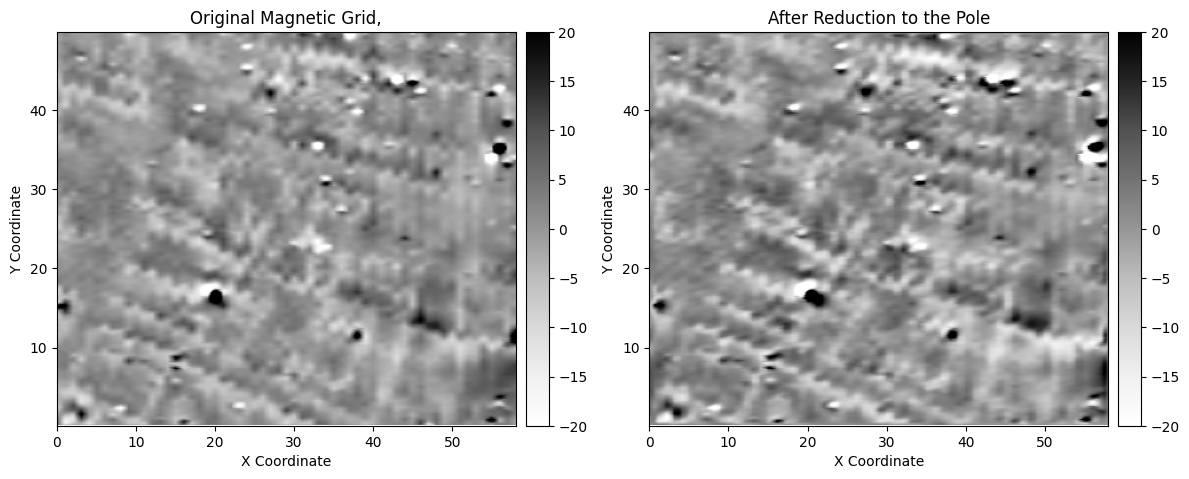

In [3]:
# We will use a processed survey for the best result
if 'mag_survey' in locals() and mag_survey.grid:
    valmin, valmax = -20, 20

    # --- Define the magnetic field parameters for the survey area ---
    # These are example values; you would use the correct ones for your data's location.
    inclination = 52.88  # Geomagnetic inclination in degrees
    declination = 15.27   # Geomagnetic declination in degrees

    # --- Apply the RTP filter ---
    rtp_survey = mag_survey.reduction_to_the_pole_grid(
        inclination=inclination,
        declination=declination,
        apod_percent=0.01
    )

    # --- Visualize the Before and After ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    mag_survey.plot('2D-SURFACE', ax=ax1, title='Original Magnetic Grid,',
                    vmin=valmin, vmax=valmax)
    rtp_survey.plot('2D-SURFACE', ax=ax2, title='After Reduction to the Pole',
                    vmin=valmin, vmax=valmax)
    
    plt.tight_layout()
    plt.show()

### 6. Euler Deconvolution for Source Location

Euler deconvolution is a powerful interpretation technique used to automatically estimate the location (x, y) and depth (z) of magnetic sources. It works by solving Euler's homogeneity equation over a moving window on the grid.

We will:
1.  Run the `euler_deconvolution()` method to calculate potential source locations.
2.  Use the specialized `plot_euler_solutions()` method to visualize the results on top of our magnetic map.

Found 7 potential solutions.


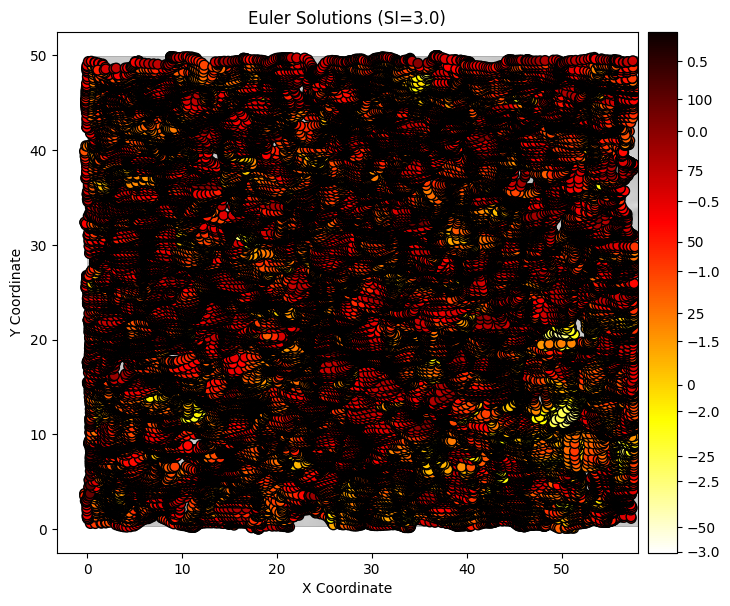

In [23]:
# We will use a processed survey for the best result
if 'mag_survey' in locals() and mag_survey.grid:
    # --- 1. Perform Euler Deconvolution ---
    # We need to choose a structural index (SI) based on the expected geology.
    # SI = 1 is often used for dikes or the edges of thin sheets.
    structural_index = 3.0
    
    euler_solutions = mag_survey.euler_deconvolution(
        structural_index=structural_index,
        window_size=15 # A larger window is sensitive to deeper sources
    )

    print(f"Found {len(euler_solutions)} potential solutions.")

    # --- 2. Visualize the Solutions ---
    # We can filter the solutions before plotting, for example, by depth.
    filtered_solutions = euler_solutions

    #print(euler_solutions)
#    filtered_solutions = euler_solutions[
#        (euler_solutions['z0_depth'] > 0) & (euler_solutions['z0_depth'] < 20)
#    ]
    #print(f"Displaying {len(filtered_solutions)} solutions with depth between 0 and 20m.")

    # Use the specialized plotting method to overlay the results
    fig, ax = mag_survey.plot_euler_solutions(
        solutions=filtered_solutions,
        title=f'Euler Solutions (SI={structural_index})'
    )


    
    plt.show()

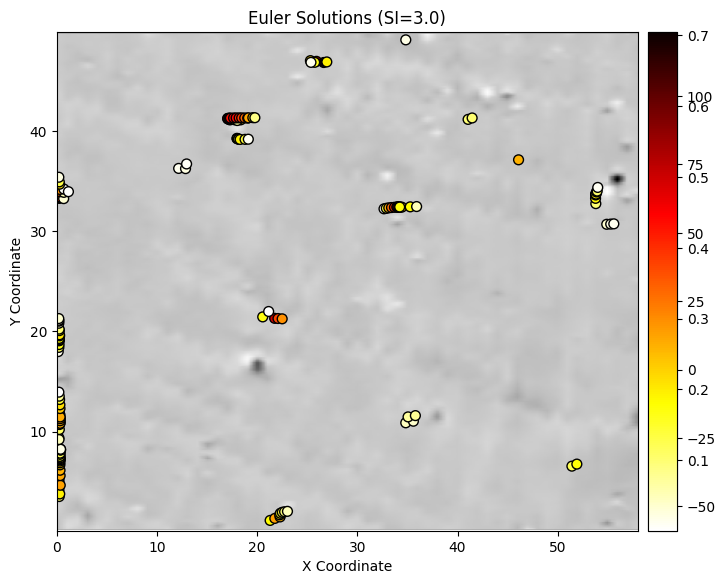

In [29]:
idx = np.logical_and(np.array(euler_solutions['z0_depth'])>0, np.array(euler_solutions['z0_depth'])<100)
len(np.array(euler_solutions['z0_depth'])[idx])
filtered_solutions = {'x0': np.array(euler_solutions['x0'])[idx],
                      'y0': np.array(euler_solutions['y0'])[idx],
                      'z0_depth': np.array(euler_solutions['z0_depth'])[idx]}

fig, ax = mag_survey.plot_euler_solutions(
    solutions=filtered_solutions,
    title=f'Euler Solutions (SI={structural_index})')
plt.show()
#print(euler_solutions['error'])

#         (np.array(euler_solutions['z0_depth']) > 0) & (np.array(euler_solutions['z0_depth']) < 20)]
# print(f"Displaying {len(filtered_solutions)} solutions with depth between 0 and 20m.")